In [1]:
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#  Copyright (c) 2022. Mohamed Reda Bouadjenek, Deakin University              +
#           Email:  reda.bouadjenek@deakin.edu.au                              +
#                                                                              +
#  Licensed under the Apache License, Version 2.0 (the "License");             +
#   you may not use this file except in compliance with the License.           +
#    You may obtain a copy of the License at:                                  +
#                                                                              +
#                 http://www.apache.org/licenses/LICENSE-2.0                   +
#                                                                              +
#    Unless required by applicable law or agreed to in writing, software       +
#    distributed under the License is distributed on an "AS IS" BASIS,         +
#    WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  +
#    See the License for the specific language governing permissions and       +
#    limitations under the License.                                            +
#                                                                              +
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

**Notebook author:** [Mohamed Reda Bouadjenek](https://rbouadjenek.github.io/), Lecturer of Applied Artificial Intelligence,

**Institution:** Deakin University, School of Information Technology, Faculty of Sci Eng & Built Env

**Adress:** Locked Bag 20000, Geelong, VIC 3220

**Phone:** +61 3 522 78380

**Email:** reda.bouadjenek@deakin.edu.au

<img style="float: left;" src="images/deakin2.png" width="200">

# Introduction

**Welcome to the Notebook for the Deakin Simpsons Challenge 2022!**

![](images/Simpsons_cast.png)


This Notebook allows you to build a classification model for The Deakin Simpsons challenge 2022.

The **Deakin Simpsons challenge 2022** is a computer vision competition for which the goal is: given an image of simpsons and a natural language question about the image, the task is to provide an accurate natural language answer using machine learning and deep learning. The challenge is designed to provide students with the opportunity to work as team members, to compete with each other, and to enhance the student learning experience by improving their AI modeling, problem-solving, and team-working skills.



As participants, your goal is to build a machine learning model to answer a natural language question given an image of Simpsons using machine learning and deep learning.


Once you have built your model, you will have to submit it on the [CodaLab](https://codalab.lisn.upsaclay.fr/competitions/317?secret_key=1aab176a-2a97-46da-a214-711ff65b7e01) platform to be evaluated.
We evaluate the performance of your model using the [Accuracy](https://visualqa.org/evaluation.html)  on a private test set that we have directly collected and labeled from TV show episodes.
Once the evaluation completed, your entry will appear on the leaderboard to see your performance against other competitors.


In the following, we will take you through  a 6-step process to build a simple model to perform this task as follows:

1. `Setup the environment:` Thie first step consists of setting the environement and downloading the data.
2. `Preprocessing:` The second step is a preprocessing step that consists of resizing, plitting, and piping the input data.
3. `Exploring the data:` The third step consists of a simple data exploration step where you will see samples of the data and some statistics to help you in understanding the data.
4. `Designing the model:` The forth step consists of designing an architecture for the task.
5. `Traning:` The fifth step consists of starting the training process.
6. `Monitoring:` The sixth step consists of monitoring the traning process to investigate possible overfitting.
7. `Submission:` The seventh and last step will take you through the submission process.




We will evaluate the quality of the model using a new evaluation metric which is robust to inter-human variability in phrasing the answers: [Accuracy_vqa](https://visualqa.org/evaluation.html).
If you are using Google Colab, you can get the package using the following:



In [ ]:
!mkdir vqaEvaluation/
!wget --output-document=vqaEvaluation/vqa.py https://raw.githubusercontent.com/rbouadjenek/deakin-ai-challenge2022/main/vqaEvaluation/vqa.py > /dev/null 2> /dev/null
!wget --output-document=vqaEvaluation/vqaEval.py https://raw.githubusercontent.com/rbouadjenek/deakin-ai-challenge2022/main/vqaEvaluation/vqaEval.py > /dev/null 2> /dev/null


**References:**

- [VQA: Visual Question Ansewering](https://visualqa.org/)
- [VQA: Visual Question Answering (ICCV 2015)](https://arxiv.org/pdf/1505.00468.pdf)


# Setup the environment

First, you need now to load all the required packages for this Notebook.




In [52]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.saving import hdf5_format
import matplotlib.pyplot as plt
import json
import os
import numpy as np
from sklearn.utils import shuffle
from tensorflow.keras.utils import plot_model
from vqaEvaluation.vqaEval import VQAEval
from vqaEvaluation.vqa import VQA
import random
import h5py

##################
# Verifications:
#################
print('GPU is used.' if len(tf.config.list_physical_devices('GPU')) > 0 else 'GPU is NOT used.')
print("Tensorflow version: " + tf.__version__)



GPU is used.
Tensorflow version: 2.8.0


# Downloading Dataset

Now, please run the following cell to download the dataset that you will use to build your model.

In [3]:
# Traning Images
data_url = "http://206.12.93.90:8080/simpson2022_dataset/scene_img_abstract_v002_train2015.tar.gz"
zip_path = keras.utils.get_file("scene_img_abstract_v002_train2015.tar.gz", data_url, extract=True)
imgs_path_train = os.path.dirname(zip_path) + '/scene_img_abstract_v002_train2015/'

#  Validation Images
data_url = "http://206.12.93.90:8080/simpson2022_dataset/scene_img_abstract_v002_val2015.tar.gz"
zip_path = keras.utils.get_file("scene_img_abstract_v002_val2015.tar.gz", data_url, extract=True)
imgs_path_val = os.path.dirname(zip_path) + '/scene_img_abstract_v002_val2015/'

# Traning Questions
data_url = "http://206.12.93.90:8080/simpson2022_dataset/OpenEnded_abstract_v002_train2015_questions.zip"
zip_path = keras.utils.get_file("OpenEnded_abstract_v002_train2015_questions.zip", data_url,
                                cache_subdir='datasets/OpenEnded_abstract_v002_train2015_questions/', extract=True)
q_train_file = os.path.dirname(zip_path) + '/OpenEnded_abstract_v002_train2015_questions.json'

#  Validation Questions
data_url = "http://206.12.93.90:8080/simpson2022_dataset/OpenEnded_abstract_v002_val2015_questions.zip"
zip_path = keras.utils.get_file("OpenEnded_abstract_v002_val2015_questions.zip", data_url,
                                cache_subdir='datasets/OpenEnded_abstract_v002_val2015_questions/', extract=True)
q_val_file = os.path.dirname(zip_path) + '/OpenEnded_abstract_v002_val2015_questions.json'

# Traning Annotations
data_url = "http://206.12.93.90:8080/simpson2022_dataset/abstract_v002_train2015_annotations.zip"
zip_path = keras.utils.get_file("abstract_v002_train2015_annotations.zip", data_url,
                                cache_subdir='datasets/abstract_v002_train2015_annotations/', extract=True)
anno_train_file = os.path.dirname(zip_path) + '/abstract_v002_train2015_annotations.json'

# Validation Annotations
data_url = "http://206.12.93.90:8080/simpson2022_dataset/abstract_v002_val2015_annotations.zip"
zip_path = keras.utils.get_file("abstract_v002_val2015_annotations.zip", data_url,
                                cache_subdir='datasets/abstract_v002_val2015_annotations/', extract=True)
anno_val_file = os.path.dirname(zip_path) + '/abstract_v002_val2015_annotations.json'


# Data preprocessing


Define global variable that will be used for this challenge.


In [32]:
# We define the size of input images to 64x64 pixels.
img_width = 32
img_height = 32
image_size = (img_height, img_width)


<span style="color:red;font-weight:bold;font: 24px">Warning: Please do not change the cell below!</span>


In [33]:
answers = ['yes','no','0','1','2','3','4','5', # Numbers
           'black','white','red','yellow','brown','blue','gray','green','orange', # Colors
           'right','left','woman','man','day','night','open','closed','top','down','fire','water',
           'glasses','glass','tree','tv','table','couch','book','car','ball', # Objects
           'happy','sad','laughing', # Expressions
           'eating','drinking','playing','walking','reading','cooking','sitting','standing','sleeping' # Actions
           ]
num_answers = len(answers)

<span style="color:red;font-weight:bold;font: 24px">End Warning!</span>

<span style="color:red;font-weight:bold;font: 24px">----------------------------------------------------------------</span>


In [48]:
# Read the data files
q_train = json.load(open(q_train_file))
q_val = json.load(open(q_val_file))
anno_train = json.load(open(anno_train_file))
anno_val = json.load(open(anno_val_file))

# Filter questions for which the answers are not in the set of possible answers
def filter_questions(questions, annotations, answers, imgs_path):
    # Make sure the questions and annotations are alligned
    questions['questions'] = sorted(questions['questions'], key=lambda x: x['question_id'])
    annotations['annotations'] = sorted(annotations['annotations'], key=lambda x: x['question_id'])
    q_out = []
    anno_out = []
    imgs_out = []
    q_ids = []
    question_ids_set = set()
    # Filter annotations
    for annotation in annotations['annotations']:
        if annotation['multiple_choice_answer'] in answers:
            question_ids_set.add(annotation['question_id'])
            q_ids.append(annotation['question_id'])
            anno_out.append(answers.index(annotation['multiple_choice_answer']))
    # Filter images and questions
    for q in questions['questions']:
        if q['question_id'] in question_ids_set:
            # Preprocessing the question
            q_text = q['question'].lower()
            q_text = q_text.replace('?', ' ? ')
            q_text = q_text.replace('.', ' . ')
            q_text = q_text.replace(',', ' . ')
            q_text = q_text.replace('!', ' . ').strip()
            q_out.append(q_text)
            file_name = str(q['image_id'])
            while len(file_name) != 12:
                file_name = '0' + file_name
            file_name = imgs_path + questions['data_type'] + '_' + questions['data_subtype'] + '_' + file_name + '.png'
            imgs_out.append(file_name)
    return imgs_out, q_out, anno_out, q_ids


imgs_train, q_train, anno_train, q_ids_train = filter_questions(q_train, anno_train,
                                                                answers, imgs_path_train)
imgs_train, q_train, anno_train, q_ids_train = shuffle(imgs_train, q_train,
                                                       anno_train, q_ids_train, random_state=0)

imgs_val, q_val, anno_val, q_ids_val = filter_questions(q_val, anno_val,
                                                        answers, imgs_path_val)
imgs_val, q_val, anno_val, q_ids_val = shuffle(imgs_val, q_val,
                                               anno_val, q_ids_val, random_state=0)



Let's create the objects that will be used for evaluation.
See: https://visualqa.org/evaluation.html.


In [35]:
# Create vqa object and vqaRes object which will be used for evaluation
vqa_train = VQA(anno_train_file, q_train_file)
vqa_val = VQA(anno_val_file, q_val_file)


loading VQA annotations and questions into memory...
0:00:01.026383
creating index...
index created!
loading VQA annotations and questions into memory...
0:00:00.744180
creating index...
index created!


We now prepare the vocabulary to be used.


In [47]:
# Get the vocabulary
vocab_size = 15000
vocab = {}
for q in q_train:
    q = q.split(' ')
    for token in q:
        v = vocab.get(token, 0)
        vocab[token] = v + 1
vocab = list(dict(sorted(vocab.items(), key=lambda x: -x[1])[0:vocab_size]).keys())
# Mapping tokens to integers
token_to_num = keras.layers.StringLookup(vocabulary=vocab)
# Mapping integers back to original tokens
num_to_token = keras.layers.StringLookup(vocabulary=token_to_num.get_vocabulary(),
                                         invert=True)
vocab_size = token_to_num.vocabulary_size()
print(f"The size of the vocabulary ={token_to_num.vocabulary_size()}")
print("Top 20 tokens in the vocabulary: ", token_to_num.get_vocabulary()[:20])


The size of the vocabulary =4161
Top 20 tokens in the vocabulary:  ['[UNK]', '?', 'the', 'is', 'are', 'how', 'many', 'what', 'on', 'color', 'in', 'there', 'a', 'to', 'man', 'woman', 'dog', 'of', 'girl', 'does']


## Defining Map Functions

In [37]:
def encode_single_sample(img_file, q, anno):
    ###########################################
    ##  Process the Image
    ##########################################
    # 1. Read image file  
    img = tf.io.read_file(img_file)
    # 2. Decode the image
    img = tf.image.decode_jpeg(img, channels=3)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    ###########################################
    ##  Process the question
    ##########################################
    # 5. Split into list of tokens
    word_splits = tf.strings.split(q, sep=" ")
    # 6. Map tokens to indices
    q = token_to_num(word_splits)
    # 7. Return a inputs to for the model
    return (img, q), anno


## Creating `Dataset` objects

We create our `tf.data.Dataset` object that returns a new dataset containing the transformed elements, in the same order as they appeared in the input. The function `encode_single_sample` is used to change both the values and the structure of a dataset's elements.



In [38]:
# We define the batch size
batch_size = 128
# Define the trainig dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (imgs_train, q_train, anno_train)
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
        .padded_batch(batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
)
# Define the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices(
    (imgs_val, q_val, anno_val)
)
val_dataset = (
    val_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
        .padded_batch(batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
)


# Visualize the data

Let's visualize an example in our dataset, including the image, the question, and the corresponding answer.


2022-03-17 16:33:53.014340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 76 of 79
2022-03-17 16:33:53.414689: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


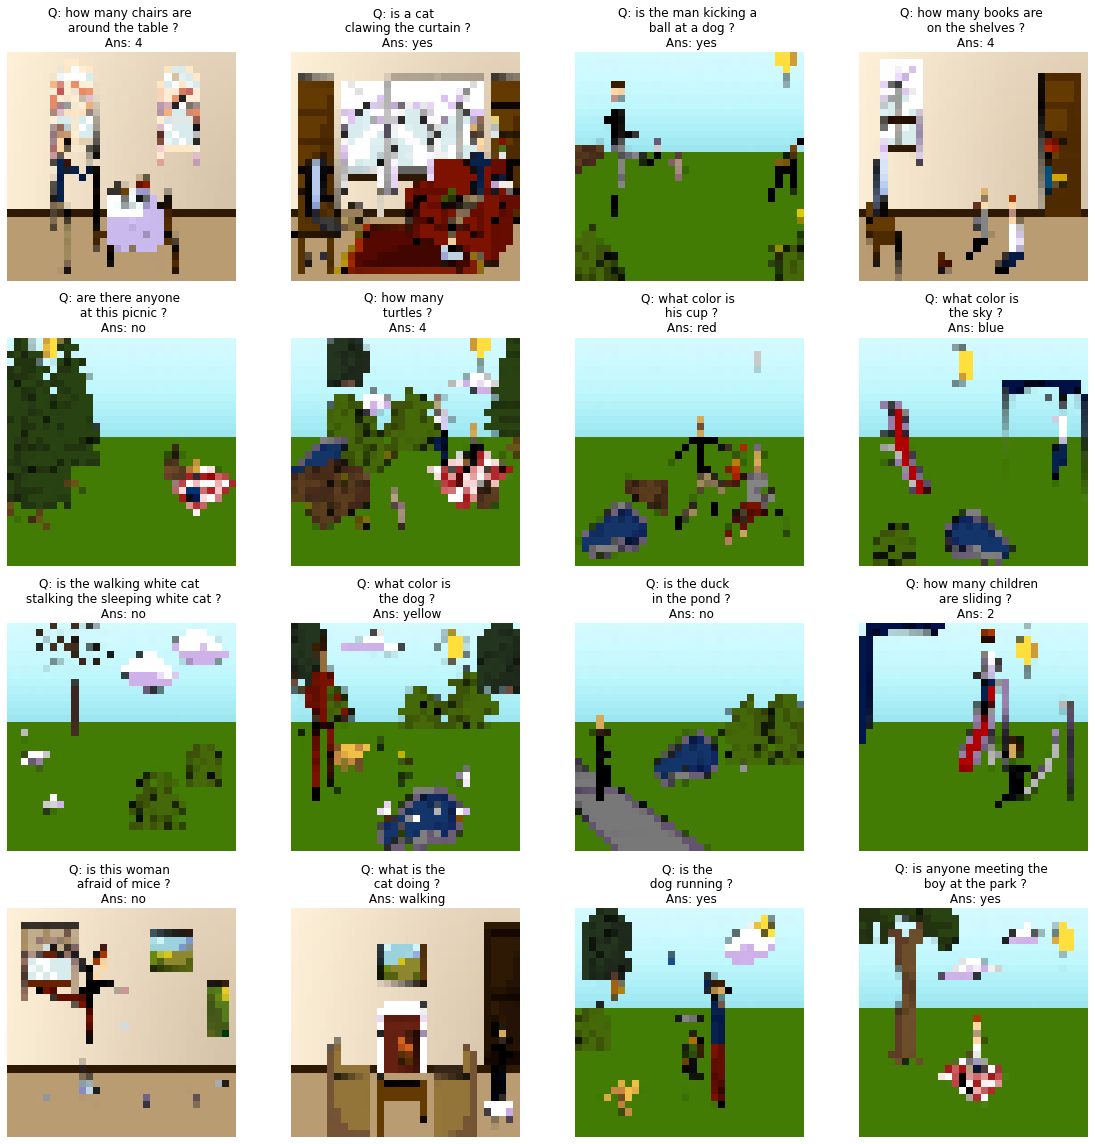

In [39]:
#  Let's check results on some validation samples
for batch in val_dataset.shuffle(random.randint(0, 200)).take(1):
    imgs_batch = batch[0][0]
    q_batch = batch[0][1]
    ans_batch = batch[1]
    answer_texts = [answers[i] for i in ans_batch]

    q_orig = []
    for q in q_batch:
        q = num_to_token(q).numpy()
        q = [t.decode("utf-8") for t in q]
        q = list(filter(('[UNK]').__ne__, q))
        q.insert(int(len(q) / 2), '\n')
        q = ' '.join(q)
        q_orig.append(q)

    _, ax = plt.subplots(4, 4, figsize=(16, 16))
    for i in range(16):
        img = (imgs_batch[i, :, :, :] * 255).numpy().astype(np.uint8)
        title = f"Q: {q_orig[i]}\n Ans: {answer_texts[i]}"
        ax[i // 4, i % 4].imshow(img)
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

    plt.tight_layout()
    plt.show()


# Model

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 input_question (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 flatten_5 (Flatten)            (None, 3072)         0           ['input_image[0][0]']            
                                                                                                  
 embedding_5 (Embedding)        (None, None, 20)     83220       ['input_question[0][0]']         
                                                                                            

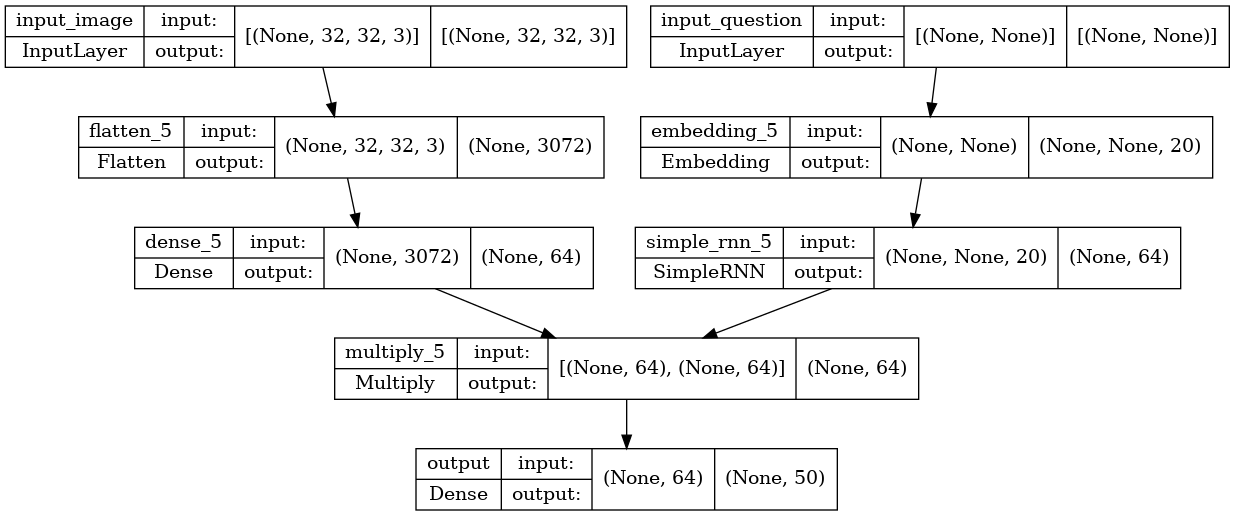

In [53]:
# This model is the deeper LSTM Q from Figure 8 in
# https://arxiv.org/pdf/1505.00468.pdf
def build_model(img_size, vocab_size, num_answers):
    # Define the VGG19 conv_base for image input
    img_input = keras.Input(shape=img_size + (3,), name="input_image")
    img = layers.Flatten()(img_input)
    img = layers.Dense(64, activation='relu')(img)
    #Define RNN for language input
    q_input = keras.Input(shape=(None,), name="input_question")
    q = layers.Embedding(input_dim=vocab_size, output_dim=20)(q_input)
    q = layers.SimpleRNN(64)(q)
    # Combine CNN and RNN
    mrg = layers.Multiply()([img, q])
    # Output    
    output = layers.Dense(num_answers, activation='softmax', name="output")(mrg)
    vqa_model = keras.Model(inputs=[img_input, q_input], outputs=output)
    vqa_model.compile(keras.optimizers.Adam(learning_rate=1e-4),
                      loss='sparse_categorical_crossentropy')
    return vqa_model


# Get the model
model = build_model(image_size, vocab_size, num_answers)
model.summary()
plot_model(model, show_shapes=True)


# Training and Evaluating

In [13]:
# A utility function assess the model using the metrics suggested in:
# https://visualqa.org/evaluation.html.
def evaluate_model(model, dataset, vqa, q_ids, q_file):
    preds = model.predict(dataset)
    preds = np.argmax(preds, axis=1)
    res = []
    for i in range(len(preds)):
        res.append({'question_id': q_ids[i], "answer": answers[preds[i]]})
    vqaRes = vqa.loadRes(res, q_file)
    # create vqaEval object by taking vqa and vqaRes
    vqaEval = VQAEval(vqa, vqaRes, n=4)
    # evaluate results
    vqaEval.evaluate(quesIds=q_ids)
    return vqaEval


# A callback class to check overall accuracy as suggested in
# https://visualqa.org/evaluation.html.
class CallbackEval(keras.callbacks.Callback):
    """Displays Accuracy for each epoch."""

    def __init__(self, dataset, vqa, q_ids, q_file, data_type='training'):
        super().__init__()
        self.dataset = dataset
        self.vqa = vqa
        self.q_ids = q_ids
        self.q_file = q_file
        self.overall_accuracy = []
        self.data_type = data_type

    def on_epoch_end(self, epoch: int, logs=None):
        vqaEval = evaluate_model(model, self.dataset,
                                 self.vqa,
                                 self.q_ids,
                                 self.q_file)
        self.overall_accuracy.append(vqaEval.accuracy['overall'])
        print('-' * 50)
        print("Epoch: " + str(epoch + 1) +
              " - Overall Accuracy for " + self.data_type +
              " set is: %.02f" % (vqaEval.accuracy['overall']))
        print('-' * 50)


In [43]:
# Define the number of epochs.
epochs = 1
# Callback functions to check overall accuracy as suggested in 
# https://visualqa.org/evaluation.html.
train_callback = CallbackEval(train_dataset,
                              vqa_train,
                              q_ids_train,
                              q_train_file)
val_callback = CallbackEval(val_dataset,
                            vqa_val,
                            q_ids_val,
                            q_val_file,
                            data_type='validation')
# Train the model
history = model.fit(
    train_dataset,
    epochs=epochs,
    callbacks=[train_callback, val_callback],
)
# Put training data in the history
history.history['overall_accuracy'] = train_callback.overall_accuracy
history.history['val_overall_accuracy'] = val_callback.overall_accuracy



Epoch 1/10
321/322 [============================>.] - ETA: 0s - loss: 1.9824Loading and preparing results...     
DONE (t=0.06s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% Done computing accuracy
--------------------------------------------------
Epoch: 1 - Overall Accuracy for training set is: 51.86
--------------------------------------------------
Loading and preparing results...     
DONE (t=0.03s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% Done computing accuracy
--------------------------------------------------
Epoch: 1 - Overall Accuracy for validation set is: 52.21
--------------------------------------------------
322/322 [==============================] - 105s 326ms/step - loss: 1.9821
Epoch 2/10
321/322 [============================>.] - ETA: 0s - loss: 1.4778Loading and preparing results...     
DONE (t=0.06s)
creating index...
index created!
computing accuracy
Finshed

Save the created model. It is important to note that we are saving with the model:
1. The `answers`: which is important for submission as we will submit answers and not indexes.
1. The `token_to_num`: which is important for submission as il allows to map tokens to indexes.
2. The `image_size`: which is important to resize the test images.

In [44]:
with h5py.File('model.h5', mode='w') as f:
    hdf5_format.save_model_to_hdf5(model, f)
    f.attrs['answers'] = answers
    f.attrs['image_size'] = image_size
    # The vocabulary is stored in two parts.
    f.attrs['vocab1'] = vocab[0:2048]
    f.attrs['vocab2'] = vocab[2048:]


# Monitoring and analysis of the model

The next step consists of monitoring the traning process to investigate possible overfitting.


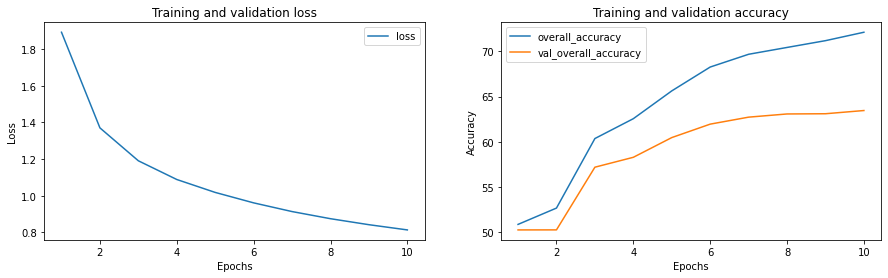

In [25]:
def learning_plots(history):
    plt.figure(figsize=(15, 4))
    ax1 = plt.subplot(1, 2, 1)
    for l in history.history:
        if l == 'loss' or l == 'val_loss':
            loss = history.history[l]
            plt.plot(range(1, len(loss) + 1), loss, label=l)

    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    ax2 = plt.subplot(1, 2, 2)
    for k in history.history:
        if 'accuracy' in k:
            loss = history.history[k]
            plt.plot(range(1, len(loss) + 1), loss, label=k)
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


learning_plots(history)


In [30]:
vqaEval_val = evaluate_model(model, val_dataset, vqa_val, q_ids_val, q_val_file)
print("Overall Accuracy is: %.02f\n" % (vqaEval_val.accuracy['overall']))
print("Per Answer Type Accuracy is the following:")
for ansType in vqaEval_val.accuracy['perAnswerType']:
    print("%s : %.02f" % (ansType, vqaEval_val.accuracy['perAnswerType'][ansType]))


Loading and preparing results...     
DONE (t=0.03s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% Done computing accuracy
Overall Accuracy is: 63.45

Per Answer Type Accuracy is the following:
yes/no : 75.19
other : 50.99
number : 40.96


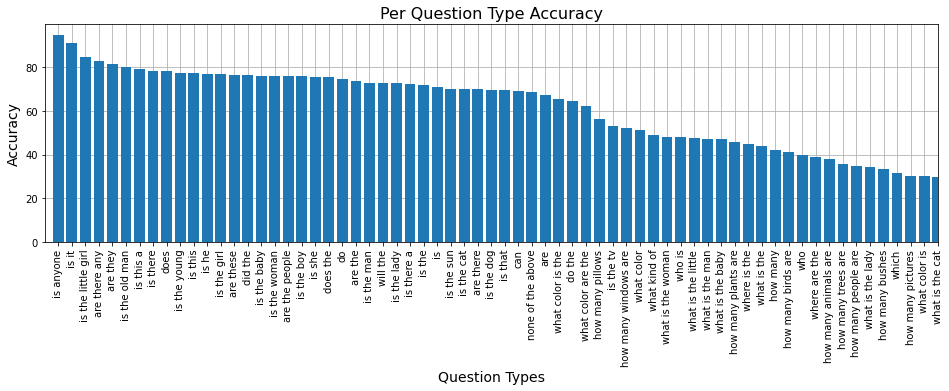

In [31]:
# plot accuracy for various question types
data = dict(sorted(vqaEval_val.accuracy['perQuestionType'].items(), key=lambda x: -x[1]))
plt.figure(figsize=(16, 4))
plt.grid()
plt.gca().set_axisbelow(True)
plt.bar(range(len(data)), data.values(), align='center')
plt.xticks(range(len(data)), data.keys(), rotation='90', fontsize=10)
plt.title('Per Question Type Accuracy', fontsize=16)
plt.xlabel('Question Types', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xlim(-1, 65)
plt.show()


## Inference and visualization


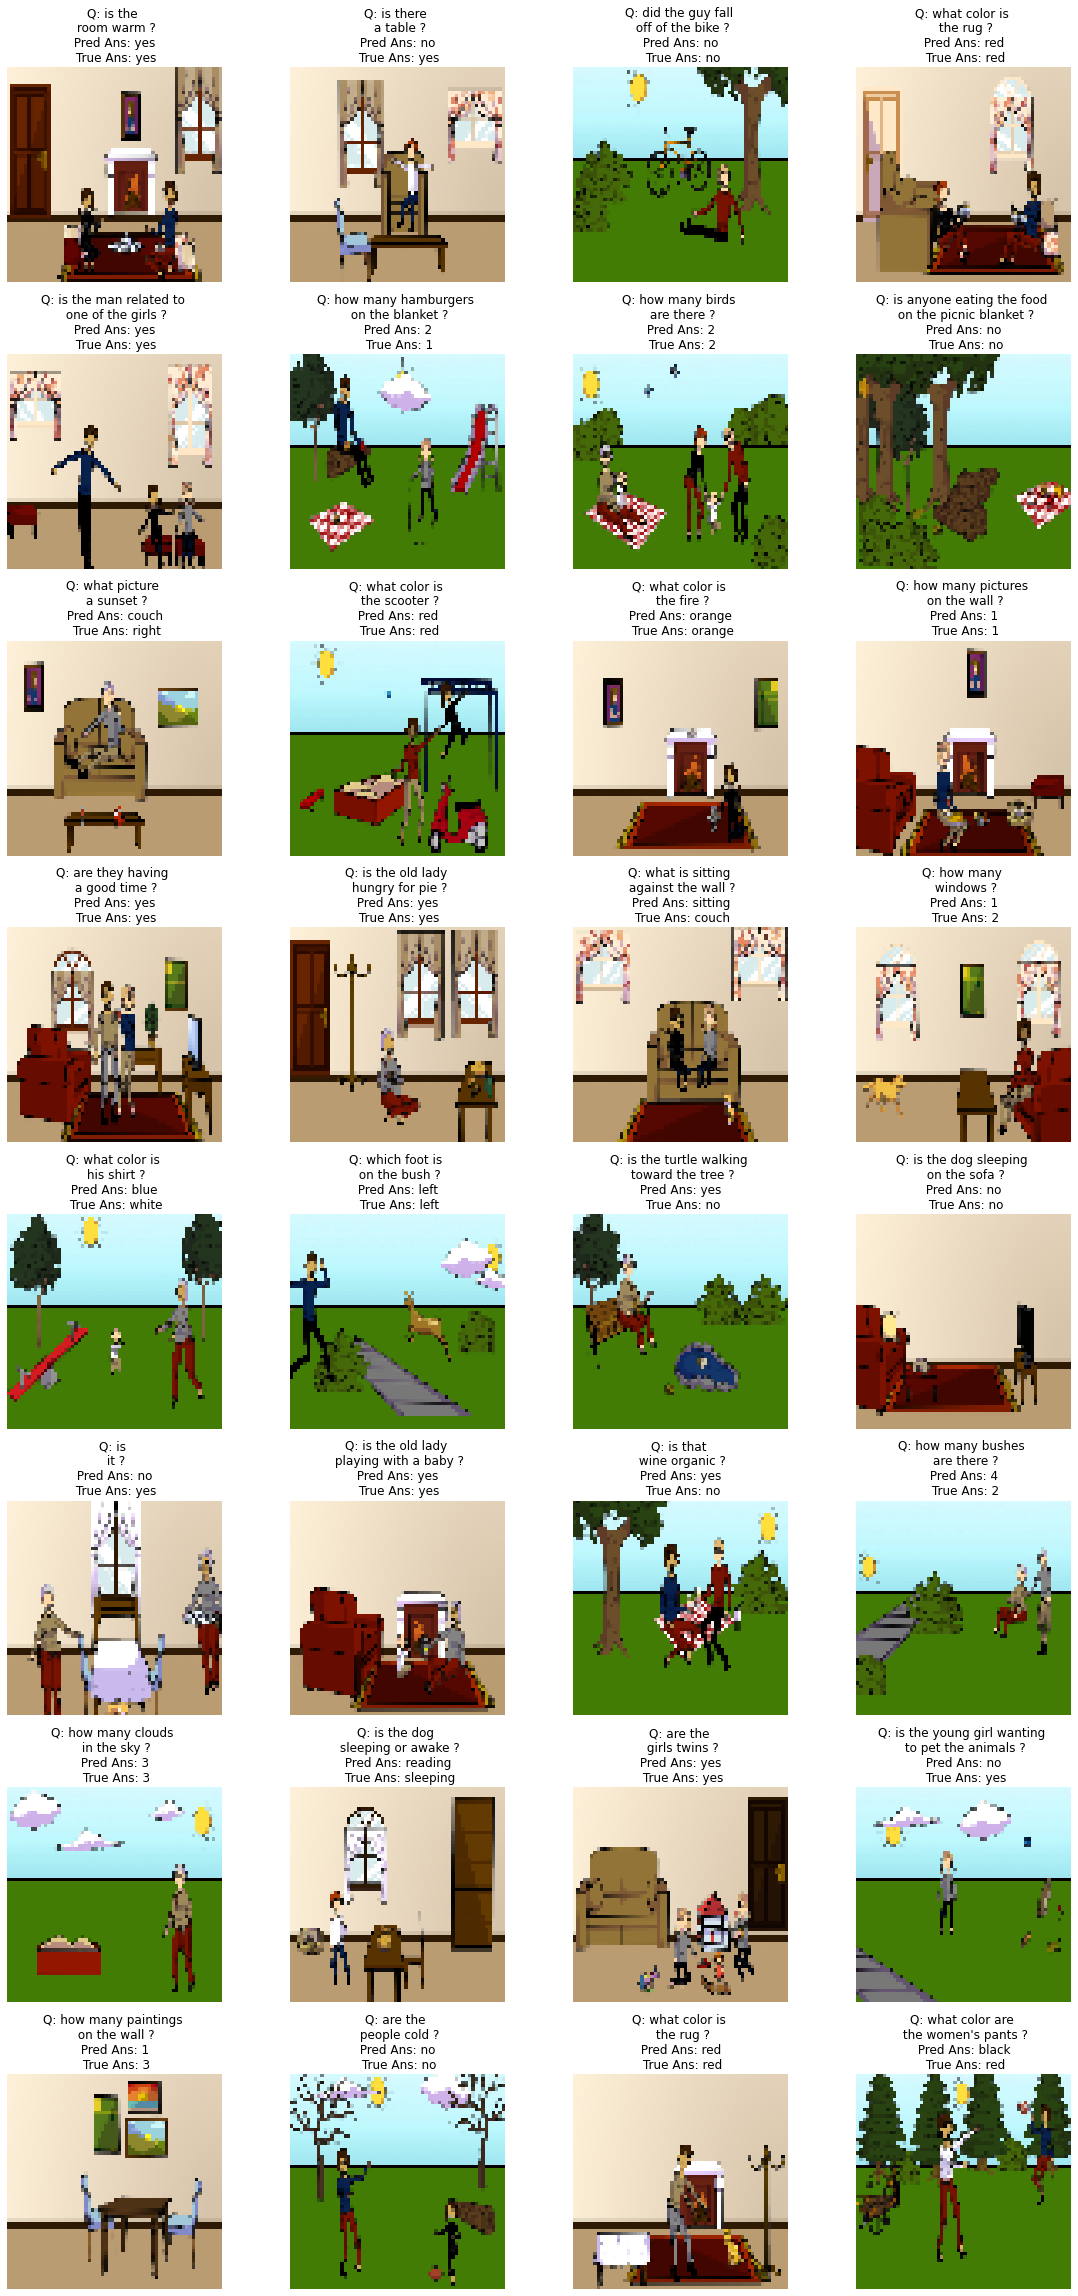

In [33]:
#  Let's check results on some validation samples

# last_conv_layer_name = 'block4_conv4'
last_conv_layer_name = 'block5_conv4'
# last_conv_layer_name = 'block5_pool'

for batch in val_dataset.shuffle(20).take(1):
    imgs_batch = batch[0][0]
    q_batch = batch[0][1]
    ans_batch = batch[1]
    answer_texts = [answers[i] for i in ans_batch]
    preds = model.predict(batch[0])
    pred_texts = [answers[i] for i in np.argmax(preds, axis=1)]
    q_orig = []
    for q in q_batch:
        q = num_to_token(q).numpy()
        q = [t.decode("utf-8") for t in q]
        q = list(filter(('[UNK]').__ne__, q))
        q.insert(int(len(q) / 2), '\n')
        q = ' '.join(q)
        q_orig.append(q)
    _, ax = plt.subplots(8, 4, figsize=(16, 32))
    for i in range(32):
        example_input = (np.array([imgs_batch[i]]), np.array([q_batch[i]]))
        title = f"Q: {q_orig[i]}\n Pred Ans: {pred_texts[i]} \n True Ans: {answer_texts[i]}"
        ax[i // 4, i % 4].imshow(imgs_batch[i])
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.tight_layout()
plt.show()


Observe where are the errors!

# How to submit the model to CodaLab?

Congratulation, you have sucessfully created your model and you need now to submit it to CodaLab!

CodaLab is an open-source web-based platform that enables researchers, developers, and data scientists to organize and participate to data science ana machine learning competitions.

Submitting your model to CodaLab is very simple. You need to follow the following steps:

1. Mount your Google Drive by runing this code:


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

2. Copy the model to your Google Drive by runing the following code:

In [ ]:
!cp model.h5 'drive/My Drive/'

3. Now, go to your Google Drive and you will find a file called `model.h5`.



4. Copy the model file `model.h5` you have created to the directory `deakin_ai_challenge_submission`.



5. Zip `deakin_ai_challenge_submission/` to generate `deakin_ai_challenge_submission.zip`.


6. Submit `deakin_ai_challenge_submission.zip` to CodaLab  following these steps.


6. Your submission will appear here. Just wait until it is processed (it may take time)!


***Watch the video below or click [here](https://www.youtube.com/watch?v=UVP4yATavFM):***



In [ ]:
from IPython.display import YouTubeVideo

YouTubeVideo('UVP4yATavFM', width=1000, height=600)


**Congratulation on building your model and submitting to CodaLab! We hope that your model will achieve a high accuracy on the testset.**


# Acknowledgment


**Author:** [Mohamed Reda Bouadjenek](https://rbouadjenek.github.io/), Lecturer of Applied Artificial Intelligence,

**Institution:** Deakin University, School of Information Technology, Faculty of Sci Eng & Built Env

**Adress:** Locked Bag 20000, Geelong, VIC 3220

**Phone:** +61 3 522 78380

**Email:** reda.bouadjenek@deakin.edu.au

**www.deakin.edu.au**

<div>
<img style="float: left;" src="images/deakin2.png" width="200" >
</div>
<br>
<br>
<br>
<br>

<div>  <a href="https://twitter.com/DeakinAI2021" > <img style="float: left;" src="https://irisconnect.com/uk/wp-content/uploads/sites/3/2020/12/twitter-Follow-us-button.png" width="200" > </a>
</div>